# 8. Συζήτηση και Συμπεράσματα

Στο παρόν κεφάλαιο αναλύονται τα πειραματικά αποτελέσματα της διπλωματικής εργασίας. Η αξιολόγηση των μοντέλων ανέδειξε σημαντικά ευρήματα σχετικά με τη φύση των UMAP embeddings και την επίδραση της κανονικοποίησης (Scaling) στην απόδοση των αλγορίθμων.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 12

data = {
    "Model_Name": [
        "Gradient Boosting",
        "Logistic Regression",
        "SGD Classifier",
        "SVM (RBF)",
        "SVM (RBF)",
        "Logistic Regression"
    ],
    "Configuration": [
        "No Scaling (Best model)",
        "No Scaling",
        "No Scaling",
        "No Scaling",
        "With Scaling",
        "With Scaling"
    ],
    "Accuracy": [0.9087, 0.8934, 0.8903, 0.8868, 0.7135, 0.7020],
    "F1_Score": [0.8784, 0.8570, 0.8500, 0.8475, 0.7022, 0.6960],
    "Scaling": ["NO", "NO", "NO", "NO", "YES", "YES"],
    "Category": ["Tree-based", "Linear", "Linear", "Kernel-based", "Kernel-based", "Linear"]
}

df_results = pd.DataFrame(data)
df_results["Display_Label"] = df_results["Model_Name"] + " (" + df_results["Scaling"] + " Scaling)"
df_results.loc[0, "Display_Label"] = "Gradient Boosting (No Scaling)"
df_results = df_results.sort_values(by="F1_Score", ascending=False).reset_index(drop=True)
df_results[['Model_Name', 'Scaling', 'Accuracy', 'F1_Score']]

,Model_Name,Scaling,Accuracy,F1_Score
0,Gradient Boosting,NO,0.9087,0.8784
1,Logistic Regression,NO,0.8934,0.8570
2,SGD Classifier,NO,0.8903,0.8500
3,SVM (RBF),NO,0.8868,0.8475
4,SVM (RBF),YES,0.7135,0.7022
5,Logistic Regression,YES,0.7020,0.6960


### 8.1. Το Παράδοξο της Κλιμάκωσης (The Scaling Anomaly)

**Ερμηνεία:**
Το φαινόμενο αυτό ερμηνεύεται από τη φύση του αλγορίθμου UMAP. Το UMAP δεν τοποθετεί τα σημεία τυχαία στον χώρο των 500 διαστάσεων· κωδικοποιεί δομική πληροφορία όχι μόνο στη **θέση** αλλά και στην **πυκνότητα** και την **κλίμακα** των διαστάσεων.

Η "βίαιη" κανονικοποίηση (mean=0, variance=1) μέσω του StandardScaler πιθανότατα ενίσχυσε τον θόρυβο στις δευτερεύουσες διαστάσεις, καταστρέφοντας την τοπολογική δομή (manifold structure) που είχε διατηρηθεί από τα **Gemma Embeddings + UMAP**, καθιστώντας τις κλάσεις λιγότερο διαχωρίσιμες.

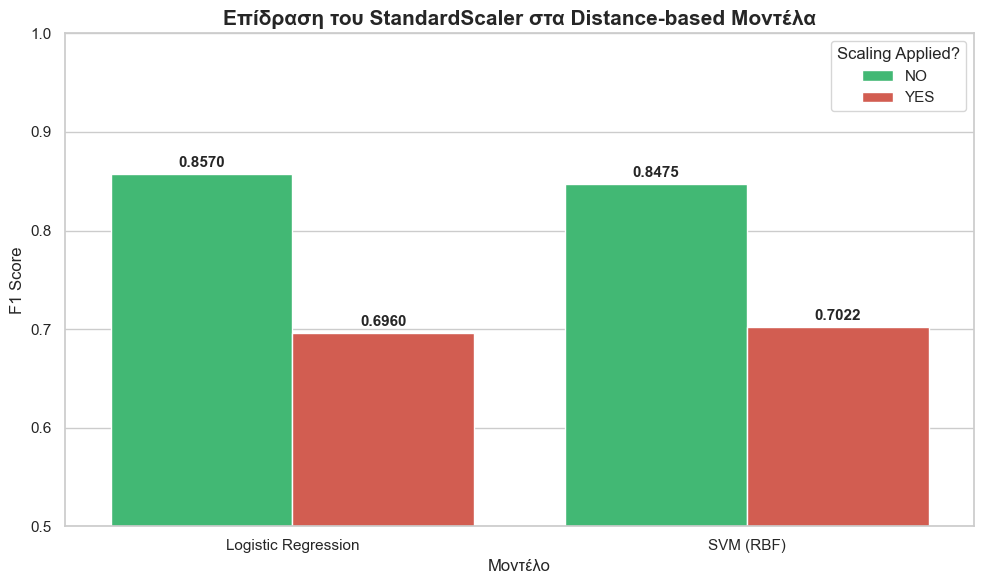

In [27]:
scaling_df = df_results[df_results["Model_Name"].isin(["SVM (RBF)", "Logistic Regression"])].copy()
plt.figure(figsize=(10, 6))
palette = {"NO": "#2ecc71", "YES": "#e74c3c"}

ax = sns.barplot(
    data=scaling_df,
    x="Model_Name",
    y="F1_Score",
    hue="Scaling",
    palette=palette
)

plt.title("Επίδραση του StandardScaler στα Distance-based Μοντέλα", fontsize=15, fontweight='bold')
plt.ylabel("F1 Score")
plt.xlabel("Μοντέλο")
plt.ylim(0.5, 1.0) # Zoom για να φανεί η διαφορά
plt.legend(title="Scaling Applied?")

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

**Ερμηνεία:**
Το φαινόμενο αυτό ερμηνεύεται από τη φύση του αλγορίθμου UMAP. Το UMAP δεν τοποθετεί τα σημεία τυχαία στον χώρο των 500 διαστάσεων· κωδικοποιεί δομική πληροφορία όχι μόνο στη **θέση** αλλά και στην **πυκνότητα** και την **κλίμακα** των διαστάσεων.

Η "βίαιη" κανονικοποίηση (mean=0, variance=1) μέσω του StandardScaler πιθανότατα ενίσχυσε τον θόρυβο στις δευτερεύουσες διαστάσεις, καταστρέφοντας την τοπολογική δομή (manifold structure) που είχε διατηρηθεί από το BERT+UMAP, καθιστώντας τις κλάσεις λιγότερο διαχωρίσιμες.

### 8.2. Ανάδειξη του Champion Model (Gradient Boosting)

Ο αλγόριθμος **Gradient Boosting** αναδείχθηκε ως το βέλτιστο μοντέλο για την ανίχνευση Clickbait, ξεπερνώντας οριακά αλλά σταθερά τα γραμμικά μοντέλα.

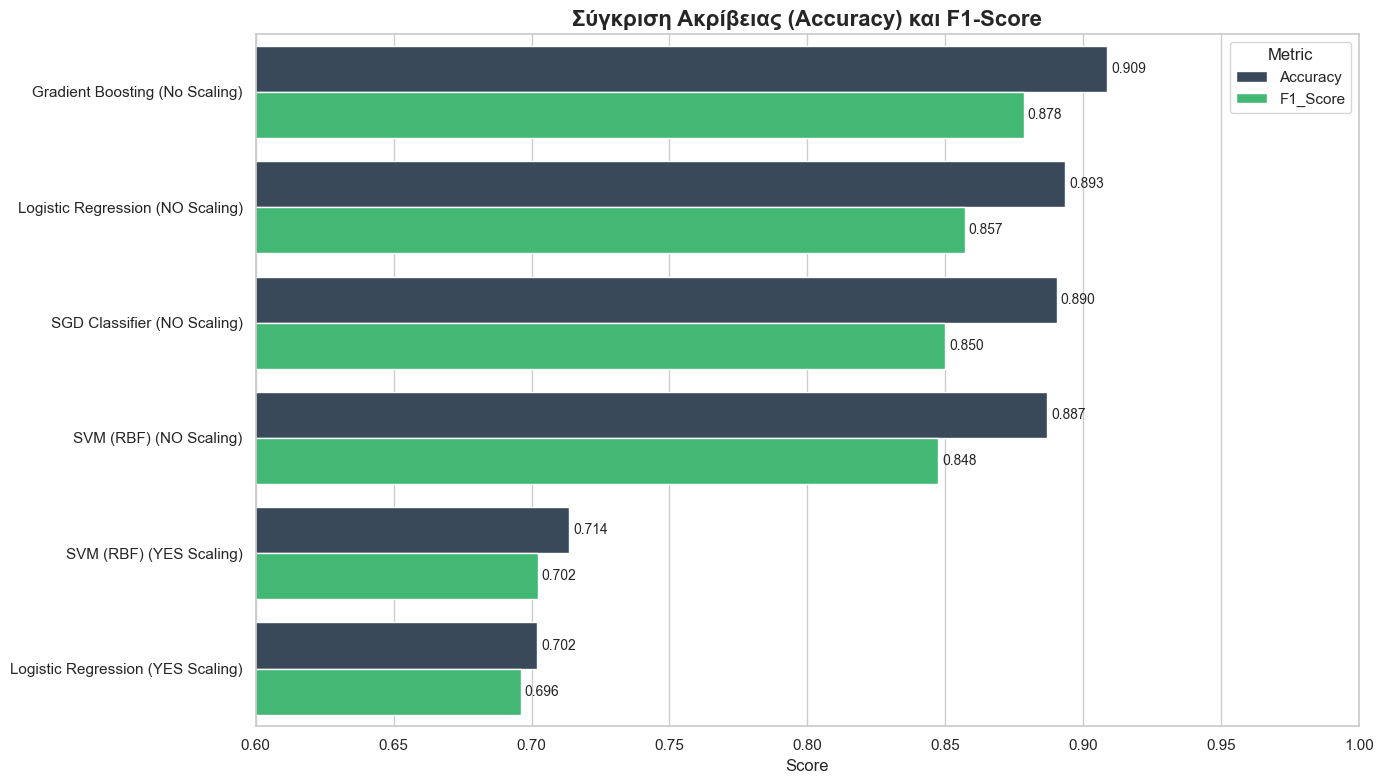

In [28]:
# Μετατροπή των δεδομένων σε "long format" για να τα σχεδιάσει το Seaborn δίπλα-δίπλα
df_melted = df_results.melt(
    id_vars=["Display_Label"],
    value_vars=["Accuracy", "F1_Score"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(14, 8))

# Χρωματική παλέτα: Μπλε για Accuracy, Πράσινο για F1
bar_plot = sns.barplot(
    data=df_melted,
    x="Score",
    y="Display_Label",
    hue="Metric",
    palette={"Accuracy": "#34495e", "F1_Score": "#2ecc71"}
)

plt.title("Σύγκριση Ακρίβειας (Accuracy) και F1-Score", fontsize=16, fontweight='bold')
plt.xlabel("Score")
plt.ylabel("")
plt.xlim(0.6, 1.0) # Zoom in
plt.legend(title="Metric")

# Προσθήκη τιμών
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/gt/16rl7qln7xbbhjw7wqx2xvkr0000gn/T/ipykernel_20686/4073853192.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


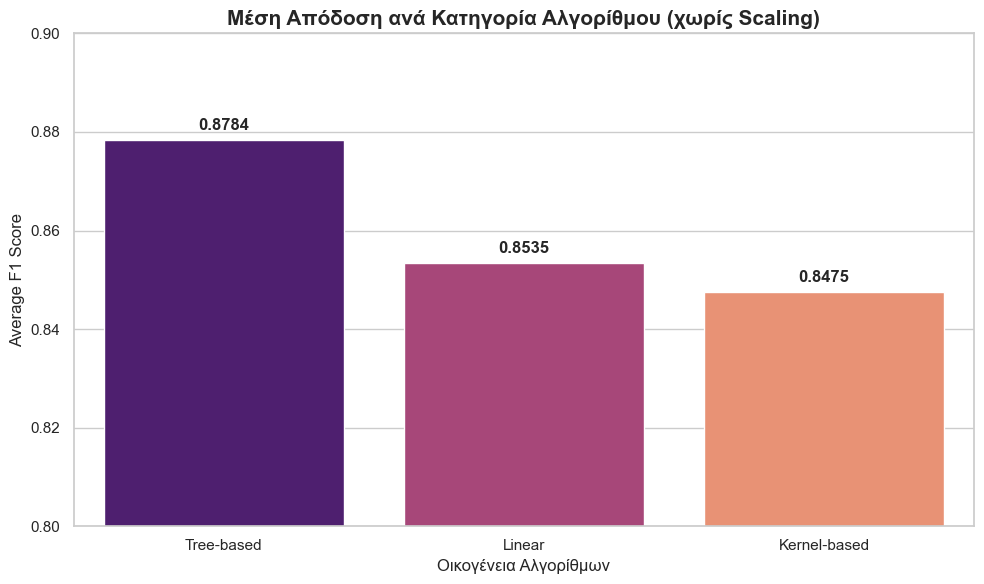

In [29]:
# Υπολογισμός μέσου όρου F1 ανά κατηγορία (εξαιρούμε τις scaled αποτυχίες για δίκαιη σύγκριση)
df_clean = df_results[df_results["Scaling"].isin(["NO", "None"])].copy()
category_perf = df_clean.groupby("Category")["F1_Score"].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))

# Χρωματισμός ανάλογα με την απόδοση
pal = sns.color_palette("magma", len(category_perf))

ax = sns.barplot(
    data=category_perf,
    x="Category",
    y="F1_Score",
    palette=pal
)

plt.title("Μέση Απόδοση ανά Κατηγορία Αλγορίθμου (χωρίς Scaling)", fontsize=15, fontweight='bold')
plt.ylabel("Average F1 Score")
plt.xlabel("Οικογένεια Αλγορίθμων")
plt.ylim(0.8, 0.9) # Πολύ συγκεκριμένο zoom

# Ετικέτες
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=5, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Ανάλυση:**
Η υπεροχή του Gradient Boosting (**F1: 0.8784**) οφείλεται στην ικανότητα του να διαχειρίζεται μη-γραμμικά όρια αποφάσεων και στην **ανοσία του στην κλιμάκωση (scale invariance)**.

* Ως δενδρικό μοντέλο, βασίζεται σε κανόνες διαχωρισμού (`if feature_X > threshold`) και όχι σε ευκλείδειες αποστάσεις.
* Αυτό του επέτρεψε να εκμεταλλευτεί την πλούσια πληροφορία των UMAP embeddings αυτούσια, χωρίς να επηρεάζεται από τις διαφορές μεγέθους ή πυκνότητας των διαστάσεων.
* Επιπλέον, ο boosting μηχανισμός διαχειρίστηκε αποτελεσματικά την ανισορροπία των κλάσεων (Class Imbalance).

### 8.3. Το UMAP ως "Γραμμικοποιητής"

Αξίζει να σημειωθεί η εξαιρετικά υψηλή επίδοση της Logistic Regression χωρίς scaling (**0.8570**), η οποία πλησίασε το Gradient Boosting. Αυτό αποδεικνύει ότι το UMAP λειτούργησε επιτυχώς ως μηχανισμός "ξεδιπλώματος" (manifold unrolling). Μετέτρεψε τις πλούσιες σημασιολογικές αναπαραστάσεις του **Gemma LLM** σε έναν χώρο όπου οι κλάσεις Clickbait και Non-Clickbait είναι σχεδόν γραμμικά διαχωρίσιμες.

### 8.4. Πρόταση για Παραγωγή
Βάσει των αποτελεσμάτων, η προτεινόμενη αρχιτεκτονική για περιβάλλον παραγωγής είναι ο συνδυασμός **Parametric UMAP** (για ταχύτητα στο inference) και **Gradient Boosting Classifier** (χωρίς scaling). Ο συνδυασμός αυτός εξασφαλίζει τη μέγιστη δυνατή ακρίβεια, διατηρώντας την ανθεκτικότητα του συστήματος.